> __Purpose:__ Show how the attack model improves as we let the adversary access later decoders.  E.g., if we use an earlier decoder, does it perform worse than a later decoder (one that has had more time to adapt and personalize)? 

- 14 Subjects, therefore random guessing would be 7.14% correct on average

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *
from experiment_params import *

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
import warnings
warnings.filterwarnings("ignore")

random.seed(a=1)

# Load In Data and Set Params

In [2]:
my_models = [LogisticRegression(), KNeighborsClassifier(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

In [3]:
update_ix = np.load(r"Data\update_ix.npy")
print(update_ix.shape)
print(update_ix)

# These are the full dfs, no prefix was added in the updated save
dec_flattened_df1 = pd.read_csv("Data\dec_full_flattened_df1.csv")
dec_flattened_df2 = pd.read_csv("Data\dec_full_flattened_df2.csv")
dec_flattened_df = pd.concat((dec_flattened_df1, dec_flattened_df2))

if dec_flattened_df.columns[0]=='Unnamed: 0':
    dec_flattened_df.drop('Unnamed: 0', axis=1, inplace=True)

dec_flattened_df["List Flat Dec"] = dec_flattened_df["Flattened Decoder"].apply(lambda x: x.strip("[]").split())
dec_flattened_df.drop("Flattened Decoder", axis=1, inplace=True)
    
print(dec_flattened_df.shape)
dec_flattened_df.head()

(19,)
[    0  1200  2402  3604  4806  6008  7210  8412  9614 10816 12018 13220
 14422 15624 16826 18028 19230 20432 20769]
(2128, 4)


,Subject,Condition,Update Number,List Flat Dec
0,METACPHS_S106,0,0,"[2.72214435e-03, 2.60593156e-03, 3.08748960e-0..."
1,METACPHS_S106,0,1,"[2.72214435e-03, 2.60593156e-03, 3.08748960e-0..."
2,METACPHS_S106,0,2,"[-0.34157085, 0.08410593, -0.54057447, 0.44431..."
3,METACPHS_S106,0,3,"[-0.17386248, 0.00370517, 0.40721562, -0.51522..."
4,METACPHS_S106,0,4,"[0.83210615, -1.32612423, 0.28718983, 1.302252..."


# Compare Accuracies Of First and Last Decoders

In [4]:
flat_dec_expanded_df = pd.DataFrame()
for my_row in range(dec_flattened_df.shape[0]):
    test=pd.DataFrame(dec_flattened_df.iloc[my_row,3]).T
    flat_dec_expanded_df = pd.concat((flat_dec_expanded_df, test))

flat_dec_expanded_df.reset_index(inplace=True, drop=True)
flat_dec_expanded_df.insert(loc=0, column='Update Number', value=list(dec_flattened_df['Update Number']))
flat_dec_expanded_df.insert(loc=0, column='Condition', value=list(dec_flattened_df['Condition']))
flat_dec_expanded_df.insert(loc=0, column='Subject', value=list(dec_flattened_df['Subject']))

print(flat_dec_expanded_df.shape)
flat_dec_expanded_df.head()

(2128, 131)


,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,METACPHS_S106,0,0,2.72214435e-03,2.60593156e-03,3.08748960e-03,9.60984160e-03,9.47705955e-03,4.05088996e-03,1.24488422e-04,...,5.58792162e-03,5.06510480e-03,4.47552062e-03,4.00734563e-03,6.81589617e-03,5.03282901e-03,8.90390936e-03,5.12442669e-03,6.04637796e-03,5.62470748e-03
1,METACPHS_S106,0,1,2.72214435e-03,2.60593156e-03,3.08748960e-03,9.60984160e-03,9.47705955e-03,4.05088996e-03,1.24488422e-04,...,5.58792162e-03,5.06510480e-03,4.47552062e-03,4.00734563e-03,6.81589617e-03,5.03282901e-03,8.90390936e-03,5.12442669e-03,6.04637796e-03,5.62470748e-03
2,METACPHS_S106,0,2,-0.34157085,0.08410593,-0.54057447,0.44431971,-1.65632047,-1.08176109,1.80669107,...,0.56541071,0.12850455,0.84879963,-0.82862119,-0.45321879,0.08108862,0.41167443,0.07050124,1.24848601,-0.66642511
3,METACPHS_S106,0,3,-0.17386248,0.00370517,0.40721562,-0.51522166,-0.21700826,-0.41879839,0.28867451,...,0.14497544,-0.43663742,0.01554666,-0.26649191,-0.28757351,-0.06919594,-0.46170177,-0.39375935,0.9798836,1.42673531
4,METACPHS_S106,0,4,0.83210615,-1.32612423,0.28718983,1.30225281,-1.52349357,-1.95300335,1.08216747,...,0.14773674,-0.53839429,0.08811597,-0.28007302,0.02218175,-0.6481912,1.26977499,0.32429486,0.32709684,-2.46870643


Notice that the 0th decoder achieves 100% accuracy!

In [5]:
zero_df, zero_test_df = nth_decoder_model(flat_dec_expanded_df, 0, my_models, test=True)
zero_test_df.head(10)

,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),11.538,2.941,5,0
0,KNeighborsClassifier(),5.128,2.941,5,0
0,LinearSVC(),14.103,5.882,5,0
0,SGDClassifier(),10.256,11.765,5,0
0,DecisionTreeClassifier(),100.0,100.0,5,0
0,GradientBoostingClassifier(),100.0,100.0,5,0


Let's look at the actual decoder matrices to see why this is:

In [6]:
my_metrics_cols=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds']
key_to_num_dict=key_to_num

Observe that for Conditions (0,1), (2,3), (4,5), and (6,7), these pairs have the exact same decoder values!

In [7]:
n=0
nth_update_idxs = flat_dec_expanded_df[~(flat_dec_expanded_df['Update Number'] == n)].index
dec0_df = flat_dec_expanded_df.drop(nth_update_idxs)
dec0_df.head(8)

,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,METACPHS_S106,0,0,2.72214435e-03,2.60593156e-03,3.08748960e-03,9.60984160e-03,9.47705955e-03,4.05088996e-03,1.24488422e-04,...,5.58792162e-03,5.06510480e-03,4.47552062e-03,4.00734563e-03,6.81589617e-03,5.03282901e-03,8.90390936e-03,5.12442669e-03,6.04637796e-03,5.62470748e-03
19,METACPHS_S106,1,0,2.72214435e-03,2.60593156e-03,3.08748960e-03,9.60984160e-03,9.47705955e-03,4.05088996e-03,1.24488422e-04,...,5.58792162e-03,5.06510480e-03,4.47552062e-03,4.00734563e-03,6.81589617e-03,5.03282901e-03,8.90390936e-03,5.12442669e-03,6.04637796e-03,5.62470748e-03
38,METACPHS_S106,2,0,-5.32650851e-04,-1.35759296e-03,-9.21125191e-03,-3.42444275e-03,-2.86127032e-03,-8.23897102e-03,-6.39795370e-03,...,-2.81228606e-03,-9.09189600e-03,-4.49275178e-03,-6.45896575e-03,-1.38031322e-03,-1.83417646e-03,-6.10414240e-03,-1.41698590e-03,-4.46122929e-04,-5.28146822e-04
57,METACPHS_S106,3,0,-5.32650851e-04,-1.35759296e-03,-9.21125191e-03,-3.42444275e-03,-2.86127032e-03,-8.23897102e-03,-6.39795370e-03,...,-2.81228606e-03,-9.09189600e-03,-4.49275178e-03,-6.45896575e-03,-1.38031322e-03,-1.83417646e-03,-6.10414240e-03,-1.41698590e-03,-4.46122929e-04,-5.28146822e-04
76,METACPHS_S106,4,0,2.72214435e-03,2.60593156e-03,3.08748960e-03,9.60984160e-03,9.47705955e-03,4.05088996e-03,1.24488422e-04,...,5.58792162e-03,5.06510480e-03,4.47552062e-03,4.00734563e-03,6.81589617e-03,5.03282901e-03,8.90390936e-03,5.12442669e-03,6.04637796e-03,5.62470748e-03
95,METACPHS_S106,5,0,2.72214435e-03,2.60593156e-03,3.08748960e-03,9.60984160e-03,9.47705955e-03,4.05088996e-03,1.24488422e-04,...,5.58792162e-03,5.06510480e-03,4.47552062e-03,4.00734563e-03,6.81589617e-03,5.03282901e-03,8.90390936e-03,5.12442669e-03,6.04637796e-03,5.62470748e-03
114,METACPHS_S106,6,0,-5.32650851e-04,-1.35759296e-03,-9.21125191e-03,-3.42444275e-03,-2.86127032e-03,-8.23897102e-03,-6.39795370e-03,...,-2.81228606e-03,-9.09189600e-03,-4.49275178e-03,-6.45896575e-03,-1.38031322e-03,-1.83417646e-03,-6.10414240e-03,-1.41698590e-03,-4.46122929e-04,-5.28146822e-04
133,METACPHS_S106,7,0,-5.32650851e-04,-1.35759296e-03,-9.21125191e-03,-3.42444275e-03,-2.86127032e-03,-8.23897102e-03,-6.39795370e-03,...,-2.81228606e-03,-9.09189600e-03,-4.49275178e-03,-6.45896575e-03,-1.38031322e-03,-1.83417646e-03,-6.10414240e-03,-1.41698590e-03,-4.46122929e-04,-5.28146822e-04


Even after going to n=1 (first update), they still have the exact same values as before!

In [8]:
n=1
nth_update_idxs = flat_dec_expanded_df[~(flat_dec_expanded_df['Update Number'] == n)].index
dec1_df = flat_dec_expanded_df.drop(nth_update_idxs)
dec1_df.head(8)

,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
1,METACPHS_S106,0,1,2.72214435e-03,2.60593156e-03,3.08748960e-03,9.60984160e-03,9.47705955e-03,4.05088996e-03,1.24488422e-04,...,5.58792162e-03,5.06510480e-03,4.47552062e-03,4.00734563e-03,6.81589617e-03,5.03282901e-03,8.90390936e-03,5.12442669e-03,6.04637796e-03,5.62470748e-03
20,METACPHS_S106,1,1,2.72214435e-03,2.60593156e-03,3.08748960e-03,9.60984160e-03,9.47705955e-03,4.05088996e-03,1.24488422e-04,...,5.58792162e-03,5.06510480e-03,4.47552062e-03,4.00734563e-03,6.81589617e-03,5.03282901e-03,8.90390936e-03,5.12442669e-03,6.04637796e-03,5.62470748e-03
39,METACPHS_S106,2,1,-5.32650851e-04,-1.35759296e-03,-9.21125191e-03,-3.42444275e-03,-2.86127032e-03,-8.23897102e-03,-6.39795370e-03,...,-2.81228606e-03,-9.09189600e-03,-4.49275178e-03,-6.45896575e-03,-1.38031322e-03,-1.83417646e-03,-6.10414240e-03,-1.41698590e-03,-4.46122929e-04,-5.28146822e-04
58,METACPHS_S106,3,1,-5.32650851e-04,-1.35759296e-03,-9.21125191e-03,-3.42444275e-03,-2.86127032e-03,-8.23897102e-03,-6.39795370e-03,...,-2.81228606e-03,-9.09189600e-03,-4.49275178e-03,-6.45896575e-03,-1.38031322e-03,-1.83417646e-03,-6.10414240e-03,-1.41698590e-03,-4.46122929e-04,-5.28146822e-04
77,METACPHS_S106,4,1,2.72214435e-03,2.60593156e-03,3.08748960e-03,9.60984160e-03,9.47705955e-03,4.05088996e-03,1.24488422e-04,...,5.58792162e-03,5.06510480e-03,4.47552062e-03,4.00734563e-03,6.81589617e-03,5.03282901e-03,8.90390936e-03,5.12442669e-03,6.04637796e-03,5.62470748e-03
96,METACPHS_S106,5,1,2.72214435e-03,2.60593156e-03,3.08748960e-03,9.60984160e-03,9.47705955e-03,4.05088996e-03,1.24488422e-04,...,5.58792162e-03,5.06510480e-03,4.47552062e-03,4.00734563e-03,6.81589617e-03,5.03282901e-03,8.90390936e-03,5.12442669e-03,6.04637796e-03,5.62470748e-03
115,METACPHS_S106,6,1,-5.32650851e-04,-1.35759296e-03,-9.21125191e-03,-3.42444275e-03,-2.86127032e-03,-8.23897102e-03,-6.39795370e-03,...,-2.81228606e-03,-9.09189600e-03,-4.49275178e-03,-6.45896575e-03,-1.38031322e-03,-1.83417646e-03,-6.10414240e-03,-1.41698590e-03,-4.46122929e-04,-5.28146822e-04
134,METACPHS_S106,7,1,-5.32650851e-04,-1.35759296e-03,-9.21125191e-03,-3.42444275e-03,-2.86127032e-03,-8.23897102e-03,-6.39795370e-03,...,-2.81228606e-03,-9.09189600e-03,-4.49275178e-03,-6.45896575e-03,-1.38031322e-03,-1.83417646e-03,-6.10414240e-03,-1.41698590e-03,-4.46122929e-04,-5.28146822e-04


At n=2 we finally see some divergance

In [9]:
n=2
nth_update_idxs = flat_dec_expanded_df[~(flat_dec_expanded_df['Update Number'] == n)].index
dec2_df = flat_dec_expanded_df.drop(nth_update_idxs)
dec2_df.head(8)

,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
2,METACPHS_S106,0,2,-0.34157085,0.08410593,-0.54057447,0.44431971,-1.65632047,-1.08176109,1.80669107,...,0.56541071,0.12850455,0.84879963,-0.82862119,-0.45321879,0.08108862,0.41167443,0.07050124,1.24848601,-0.66642511
21,METACPHS_S106,1,2,-0.03235748,0.14167765,-0.93037049,-0.03263652,-0.08924583,-3.00123522,-0.07945703,...,-0.21437344,0.41984533,0.72757954,-1.0341762,2.03185923,-0.02866376,1.00642298,-0.382483,-0.23758488,-1.13089864
40,METACPHS_S106,2,2,0.82593316,-1.469018,0.5718147,0.30386287,0.20599231,0.23858401,-0.45009008,...,-0.40060644,-0.15447305,-0.32237114,0.16487292,-0.67910006,-1.08957169,-0.7687223,0.41108874,0.14403131,1.6355224
59,METACPHS_S106,3,2,-5.53875929e-01,2.23115565e-02,2.32788852e-01,-3.98969515e-01,2.06329888e-01,-3.34056245e-01,-6.72555564e-01,...,9.79034433e-01,-3.67797068e-01,1.26713365e+00,-2.87636638e+00,3.61637704e+00,3.30489530e-01,-7.98055574e-01,-3.98216587e-01,7.65683193e-02,3.44705957e+00
78,METACPHS_S106,4,2,0.02017574,0.0774387,-0.04744727,0.02543635,-0.08717858,-0.00534662,-0.07830513,...,-0.15813025,-0.0115757,-0.06737586,0.20006376,-0.15694177,-0.32726863,0.28524855,-0.02881015,0.01259228,-0.19769232
97,METACPHS_S106,5,2,3.36440079e-01,-3.69881546e-01,-1.01420276e-01,-5.63864903e-02,1.36798480e-01,-2.05442459e-01,-1.83176288e-02,...,-1.92252608e-01,1.07611608e-01,-1.95730582e-01,4.98930310e-02,9.06174933e-01,-1.28584981e+00,7.53586783e-01,1.00296093e-01,-8.92256922e-02,-3.87118059e-01
116,METACPHS_S106,6,2,9.79598938e-02,-5.03445862e-01,-3.60176767e-01,-5.31220808e-02,6.04884998e-02,1.83958533e-01,8.60718961e-01,...,2.90776148e-01,-2.35301024e-02,-7.36073186e-02,-5.03087282e-01,-1.06482447e-01,1.72972135e-01,3.02535835e-01,1.19767611e-01,-4.29825197e-01,9.57048279e-01
135,METACPHS_S106,7,2,-0.06467729,0.04125708,0.28933585,0.07843797,-0.23868005,-0.34721511,0.74531224,...,0.13753386,-0.6883625,0.18449039,0.06730907,-0.89007628,-0.34383093,1.22399979,0.50601355,0.26787942,0.01028232


# Now Observe Effect of Decoder Update Number on Performance
## n=0

In [10]:
zero_df, zero_test_df = nth_decoder_model(flat_dec_expanded_df, 0, my_models, test=True)
zero_test_df.head(10)

,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),11.538,2.941,5,0
0,KNeighborsClassifier(),5.128,2.941,5,0
0,LinearSVC(),14.103,5.882,5,0
0,SGDClassifier(),12.821,17.647,5,0
0,DecisionTreeClassifier(),100.0,100.0,5,0
0,GradientBoostingClassifier(),100.0,100.0,5,0


## Big Loop

In [11]:
print(1)
one_df, one_test_df = nth_decoder_model(flat_dec_expanded_df, 1, my_models, test=True)
two_df, two_test_df = nth_decoder_model(flat_dec_expanded_df, 2, my_models, test=True)
three_df, three_test_df = nth_decoder_model(flat_dec_expanded_df, 3, my_models, test=True)
four_df, four_test_df = nth_decoder_model(flat_dec_expanded_df, 4, my_models, test=True)
five_df, five_test_df = nth_decoder_model(flat_dec_expanded_df, 5, my_models, test=True)
six_df, six_test_df = nth_decoder_model(flat_dec_expanded_df, 6, my_models, test=True)
print(7)
seven_df, seven_test_df = nth_decoder_model(flat_dec_expanded_df, 7, my_models, test=True)
eight_df, eight_test_df = nth_decoder_model(flat_dec_expanded_df, 8, my_models, test=True)
nine_df, nine_test_df = nth_decoder_model(flat_dec_expanded_df, 9, my_models, test=True)
ten_df, ten_test_df = nth_decoder_model(flat_dec_expanded_df, 10, my_models, test=True)
ele_df, ele_test_df = nth_decoder_model(flat_dec_expanded_df, 11, my_models, test=True)
print(12)
twe_df, twe_test_df = nth_decoder_model(flat_dec_expanded_df, 12, my_models, test=True)
thirt_df, thirt_test_df = nth_decoder_model(flat_dec_expanded_df, 13, my_models, test=True)
frtn_df, frtn_test_df = nth_decoder_model(flat_dec_expanded_df, 14, my_models, test=True)
fftn_df, fftn_test_df = nth_decoder_model(flat_dec_expanded_df, 15, my_models, test=True)
sixtn_df, sixtn_test_df = nth_decoder_model(flat_dec_expanded_df, 16, my_models, test=True)
svntn_df, svntn_test_df = nth_decoder_model(flat_dec_expanded_df, 17, my_models, test=True)
print('Complete')

1
7
12
Complete


## n=18

In [12]:
eightn_df, eightn_test_df = nth_decoder_model(flat_dec_expanded_df, 18, my_models, test=True)
eightn_test_df.head(10)

,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),69.231,70.588,5,18
0,KNeighborsClassifier(),35.897,55.882,5,18
0,LinearSVC(),70.513,79.412,5,18
0,SGDClassifier(),62.821,76.471,5,18
0,DecisionTreeClassifier(),41.026,41.176,5,18
0,GradientBoostingClassifier(),43.59,52.941,5,18


## Plot Accuracy As a Func of N

In [13]:
full_test_df = pd.concat((zero_test_df, one_test_df, two_test_df, three_test_df, four_test_df, 
           five_test_df, six_test_df, seven_test_df, eight_test_df, nine_test_df, 
           ten_test_df, ele_test_df, twe_test_df, thirt_test_df, frtn_test_df, 
           fftn_test_df, sixtn_test_df, svntn_test_df, eightn_test_df))

full_test_df.drop('K Folds', axis=1, inplace=True)
print(full_test_df.shape)

(114, 4)


In [18]:
lr_df = full_test_df[full_test_df['Algorithm']=='LogisticRegression()']
knn_df = full_test_df[full_test_df['Algorithm']=='KNeighborsClassifier()']
svc_df = full_test_df[full_test_df['Algorithm']=='LinearSVC()']
sgd_df = full_test_df[full_test_df['Algorithm']=='SGDClassifier()']
dt_df = full_test_df[full_test_df['Algorithm']=='DecisionTreeClassifier()']
gbt_df = full_test_df[full_test_df['Algorithm']=='GradientBoostingClassifier()']

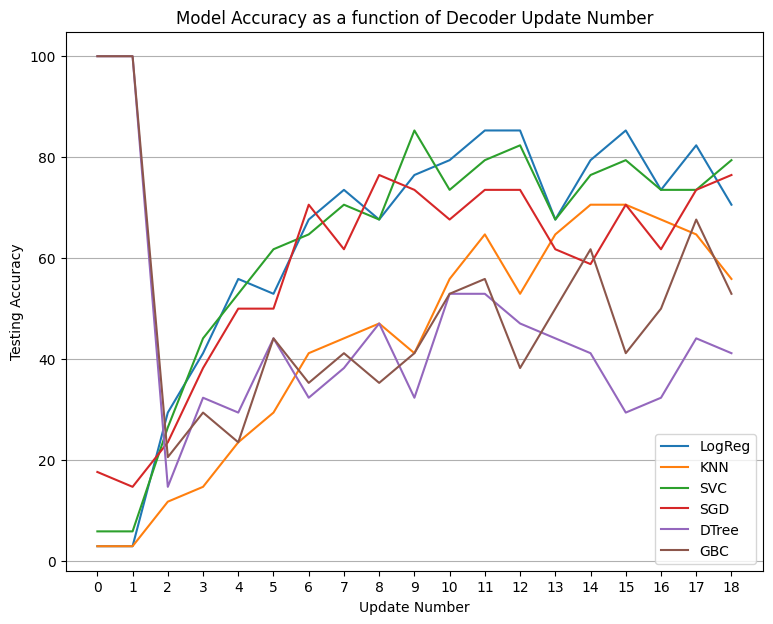

In [19]:
plt.figure(figsize=(9,7))
plt.plot(list(range(19)), lr_df.iloc[:, 2], label='LogReg')
plt.plot(list(range(19)), knn_df.iloc[:, 2], label='KNN')
plt.plot(list(range(19)), svc_df.iloc[:, 2], label='SVC')
plt.plot(list(range(19)), sgd_df.iloc[:, 2], label='SGD')
plt.plot(list(range(19)), dt_df.iloc[:, 2], label='DTree')
plt.plot(list(range(19)), gbt_df.iloc[:, 2], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

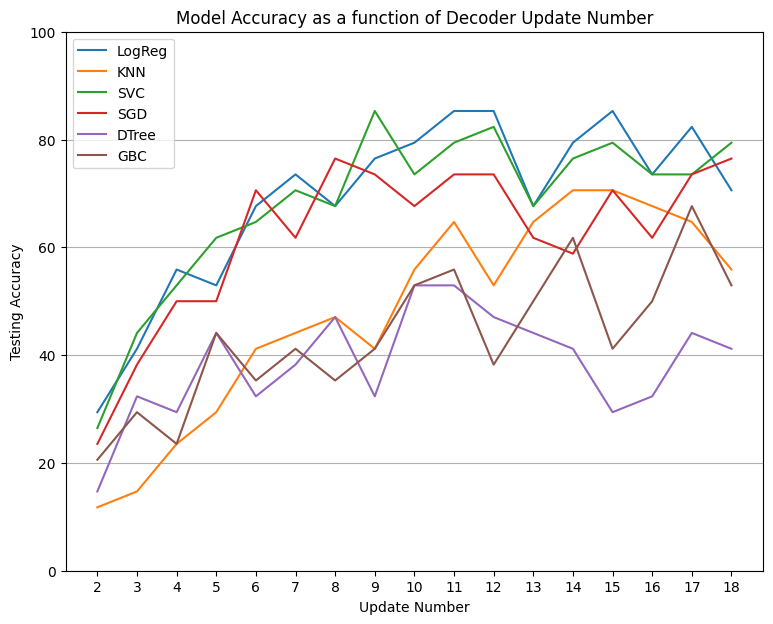

In [21]:
my_x_updates = list(range(19))[2:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, lr_df.iloc[2:, 2], label='LogReg')
plt.plot(my_x_updates, knn_df.iloc[2:, 2], label='KNN')
plt.plot(my_x_updates, svc_df.iloc[2:, 2], label='SVC')
plt.plot(my_x_updates, sgd_df.iloc[2:, 2], label='SGD')
plt.plot(my_x_updates, dt_df.iloc[2:, 2], label='DTree')
plt.plot(my_x_updates, gbt_df.iloc[2:, 2], label='GBC')
plt.xticks(np.arange(2, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

## Save Data

In [17]:
# Prevent re-saving the data
assert(1==0)

AssertionError: 

In [22]:
# Save model dfs so I don't have to rerun all this code
lr_df.to_pickle(r"Saved_Metrics\104_full_lr_df.pkl")
knn_df.to_pickle(r"Saved_Metrics\104_full_knn_df.pkl")
svc_df.to_pickle(r"Saved_Metrics\104_full_svc_df.pkl")
sgd_df.to_pickle(r"Saved_Metrics\104_full_sgd_df.pkl")
dt_df.to_pickle(r"Saved_Metrics\104_full_dt_df.pkl")
gbt_df.to_pickle(r"Saved_Metrics\104_full_gbt_df.pkl")